In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt

In [2]:
data = np.loadtxt('TSPA.csv', delimiter=';').astype(np.int16)
data.shape

(200, 3)

In [3]:
def distance(xa, ya, xb, yb):
    return round(((xa-xb)**2+(ya-yb)**2)**(1/2))
distance(1,2,4,5)

4

In [4]:
def create_cost_matrix(data):
    distance_matrix = np.empty((0,len(data)), int)
    for i in range(len(data)):
        row = []
        for j in range(len(data)):
            if i != j:
                row.append(distance(data[i][0], data[i][1], data[j][0], data[j][1]))
            else:
                row.append(0)
        distance_matrix = np.append(distance_matrix, [row], axis=0)

    costs = data[:,2]
    #print(distance_matrix)
    cost_matrix = (distance_matrix + costs)
    return cost_matrix

cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

In [5]:
def random_solution(cost_matrix, limit=100):
    random_solution_list = list(range(0,len(cost_matrix)))
    random.shuffle(random_solution_list)
    return np.array(random_solution_list)[:limit]

solution = random_solution(cost_matrix, 100)
print(solution)

[176 145 182 134 173  28 100  50  21  68  29  47 181 138 131 121 142   7
 139  94 103 133 135  23  56  38  36 152  76 104  62 118  10 117  83  49
  67  81  26  51  65  45 112  55  57 132  96 141  78   9 193 130  46 140
  80 148 175 115  91 170  34  31 147  71 122  53 123  14 199  54  63  64
 169  43 155 116  42  72  25   1 159  86  19  87 101 190  17  99 124  44
 198  16  60 128 191  35 187 125 158  70]


In [6]:
def calculate_objective_function(solution, cost_matrix):
    obj_func = 0
    for i in range(len(solution)-1):
        obj_func += cost_matrix[solution[i], solution[i+1]]
    obj_func += cost_matrix[solution[0], solution[-1]]
    return obj_func

calculate_objective_function(solution, cost_matrix)

263830

In [7]:
def nearest_neighbour(cost_matrix, current_id=random.randint(0, len(cost_matrix)-1), limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    while len(solution) < limit:
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    return np.array(solution)

solution = nearest_neighbour(cost_matrix)
print(calculate_objective_function(solution, cost_matrix))

88517


In [8]:
def greedy_cycle(cost_matrix, current_id = random.randint(0, len(cost_matrix)-1), limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    for _ in range(1):
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    
    while len(solution) < limit:
        min_delta = 99999
        min_id = -1
        insert_id = -1
        for i in range(len(solution)-1):
            for next_id in all_ids:
                delta = cost_matrix[solution[i]][next_id] + cost_matrix[next_id][solution[i+1]] - cost_matrix[solution[i]][solution[i+1]]
                if delta < min_delta:
                    min_delta = delta
                    min_id = next_id
                    insert_id = i
        for next_id in all_ids:
            delta = cost_matrix[solution[-1]][next_id] + cost_matrix[next_id][solution[0]] - cost_matrix[solution[-1]][solution[0]]
            if delta < min_delta:
                min_delta = delta
                min_id = next_id
                insert_id = i
        solution.insert(insert_id+1, min_id)
        all_ids.remove(min_id)

    return np.array(solution)
        

solution = greedy_cycle(cost_matrix)
print(calculate_objective_function(solution, cost_matrix))

76401


In [9]:
def test_solver(solver, cost_matrix, n):
    min_obj_func_value = 9999999
    max_obj_func_value = 0
    min_solution = []
    obj_values_list = []
    for i in range(n):
        solution = solver(cost_matrix, i)
        curr_obj_value = calculate_objective_function(solution, cost_matrix)
        obj_values_list.append(curr_obj_value)
        if curr_obj_value < min_obj_func_value:
            min_obj_func_value = curr_obj_value
            min_solution = solution
        if curr_obj_value > max_obj_func_value:
            max_obj_func_value = curr_obj_value
    mean_obj_func_val = sum(obj_values_list)/len(obj_values_list)
    return mean_obj_func_val, max_obj_func_value, min_obj_func_value, min_solution

In [10]:
def test_random_solver(cost_matrix, n):
    min_obj_func_value = 9999999
    max_obj_func_value = 0
    min_solution = []
    obj_values_list = []
    for _ in range(n):
        solution = random_solution(cost_matrix)
        curr_obj_value = calculate_objective_function(solution, cost_matrix)
        obj_values_list.append(curr_obj_value)
        if curr_obj_value < min_obj_func_value:
            min_obj_func_value = curr_obj_value
            min_solution = solution
        if curr_obj_value > max_obj_func_value:
            max_obj_func_value = curr_obj_value
    mean_obj_func_val = sum(obj_values_list)/len(obj_values_list)
    return mean_obj_func_val, max_obj_func_value, min_obj_func_value, min_solution

In [11]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200)
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

RANDOM SOLUTION
AVERAGE: 263946.595
MINIMUM (BEST): 238858
MAXIMUM (WORST): 286530


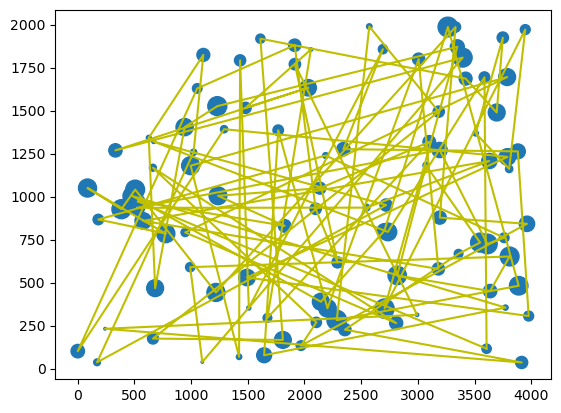

In [12]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 87741.23
MINIMUM (BEST): 84840
MAXIMUM (WORST): 95932


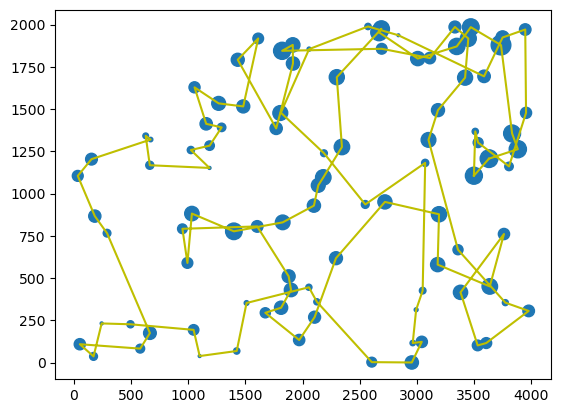

In [13]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 76387.4
MINIMUM (BEST): 74573
MAXIMUM (WORST): 79158


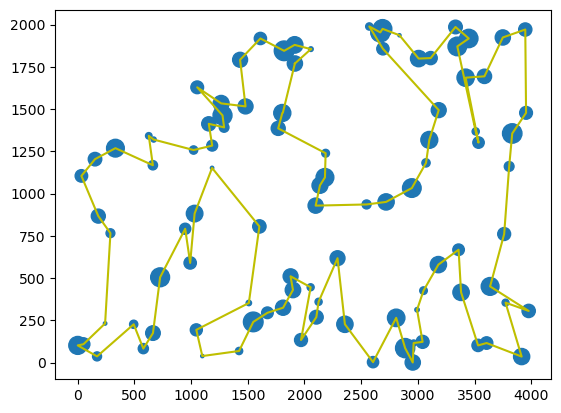

In [14]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

In [15]:
data = np.loadtxt('TSPB.csv', delimiter=';').astype(np.int16)
cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

RANDOM SOLUTION
AVERAGE: 266453.34
MINIMUM (BEST): 239354
MAXIMUM (WORST): 293122


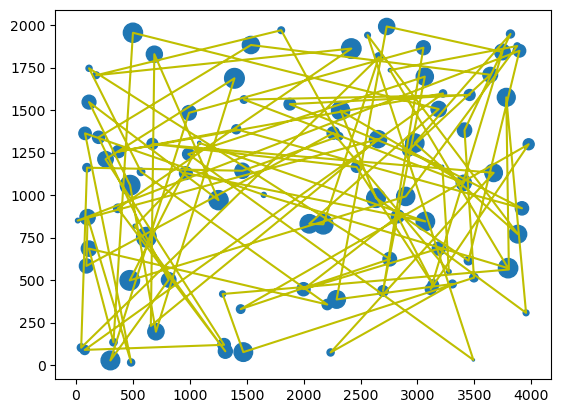

In [16]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 79096.295
MINIMUM (BEST): 77417
MAXIMUM (WORST): 81600


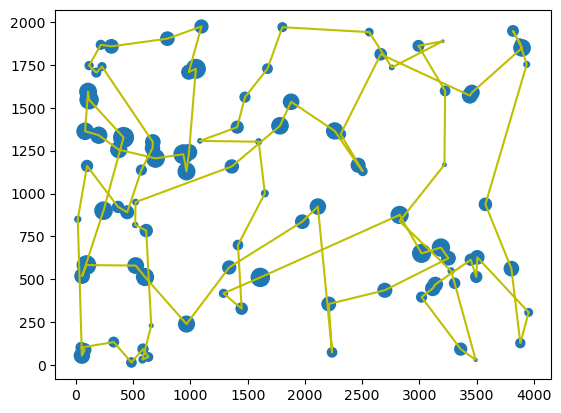

In [17]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 69961.23
MINIMUM (BEST): 67684
MAXIMUM (WORST): 75068


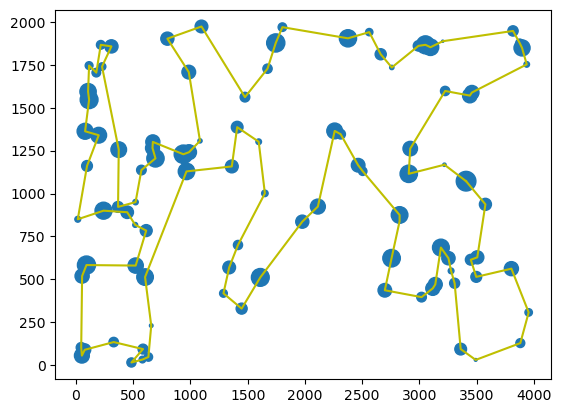

In [18]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)